# Calibrating TTim model to hypothetical pumping test

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ttim import *

### Use observation times from Oude Korendijk

In [2]:
drawdown = np.loadtxt('data/oudekorendijk_h30.dat')
tobs = drawdown[:,0] / 60 / 24
robs = 30
Q = 788

### Generate data

In [3]:
ml = ModelMaq(kaq=60, z=(-18, -25), Saq=1e-4, tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0)
ml.solve()
np.random.seed(2)
hobs = ml.head(robs, 0, tobs)[0] + 0.05 * np.random.randn(len(tobs))

self.neq  1
solution complete


### See if TTim can find aquifer parameters back
Note that the value of Saq0 is printed incorrectly to the screen in the fit report (`lmfit` will fix this hopefully in the near future - issue has be posted). The correct fitted value is printed below the fit report. 

In [4]:
cal = Calibrate(ml)
cal.set_parameter(name='kaq0', initial=100)
cal.set_parameter(name='Saq0', initial=1e-3)
cal.series(name='obs1', x=robs, y=0, layer=0, t=tobs, h=hobs)
cal.fit_least_squares(report=True)

..................................................
          optimal       std perc_std  pmin  pmax initial  \
kaq0      59.5343  2.340392  3.93117  -inf   inf     100   
Saq0  9.23965e-05  0.000012  13.4153  -inf   inf   0.001   

                       parray  
kaq0      [59.53430126639622]  
Saq0  [9.239647636997621e-05]  
[2.34039232e+00 1.23952712e-05]
[[ 5.47743623e+00 -2.46670523e-05]
 [-2.46670523e-05  1.53642747e-10]]
[[ 1.         -0.85030074]
 [-0.85030074  1.        ]]


In [5]:
cal = Calibrate(ml)
cal.set_parameter(name='kaq0', initial=100)
cal.set_parameter(name='Saq0', initial=1e-3)
cal.series(name='obs1', x=robs, y=0, layer=0, t=tobs, h=hobs)
cal.fit_lmfit()

....................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 34
    # variables        = 2
    chi-square         = 0.09714914
    reduced chi-square = 0.00303591
    Akaike info crit   = -195.167527
    Bayesian info crit = -192.114806
[[Variables]]
    kaq0:  59.5321783 +/- 2.36785111 (3.98%) (init = 100)
    Saq0:  9.2411e-05 +/- 1.2517e-05 (13.54%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.851


In [6]:
cal.parameters

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,59.5322,2.367851,3.97743,-inf,inf,100,[59.53217826635357]
Saq0,9.24106e-05,0.000013,13.5444,-inf,inf,0.001,[9.241062820300556e-05]


In [7]:
print('rmse:', cal.rmse())

rmse: 0.053453978187315954


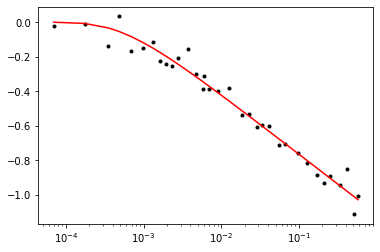

In [8]:
hm = ml.head(robs, 0, tobs, 0)
plt.semilogx(tobs, hobs, '.k')
plt.semilogx(tobs, hm[0], 'r')

In [9]:
print('correlation matrix')
print(cal.fitresult.covar)

correlation matrix
[[ 5.60671886e+00 -2.52173629e-05]
 [-2.52173629e-05  1.56662968e-10]]


## Calibrate parameters in multiple layers
Example showing how parameters can be optimized when multiple layers share the same parameter value.

In [10]:
ml = ModelMaq(kaq=[10., 10.], z=(-10, -16, -18, -25), c=[10.], Saq=[0.1, 1e-4], tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=1)
ml.solve()
hobs0 = ml.head(robs, 0, tobs, layers=[0])[0]
hobs1 = ml.head(robs, 0, tobs, layers=[1])[0]

self.neq  1
solution complete


In [11]:
cal.parameters

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,59.5322,2.367851,3.97743,-inf,inf,100,[59.53217826635357]
Saq0,9.24106e-05,0.000013,13.5444,-inf,inf,0.001,[9.241062820300556e-05]


In [12]:
cal = Calibrate(ml)
cal.set_parameter(name='kaq0_1', initial=20., pmin=0., pmax=30.)  # layers 0 and 1 have the same k-value
cal.set_parameter(name='Saq0', initial=1e-3, pmin=1e-5, pmax=0.2)
cal.set_parameter(name='Saq1', initial=1e-3, pmin=1e-5, pmax=0.2)
cal.set_parameter(name='c1', initial=1., pmin=0.1, pmax=200.)
cal.series(name='obs0', x=robs, y=0, layer=0, t=tobs, h=hobs0)
cal.series(name='obs1', x=robs, y=0, layer=1, t=tobs, h=hobs1)
cal.fit(report=False)
display(cal.parameters)

...................................................................................................
Fit succeeded.


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_1,9.999615,1.202124e-04,0.001202,0.00000,30.0,20.000,"[9.999614963245097, 9.999614963245097]"
Saq0,0.100003,1.774012e-07,0.000177,0.00001,0.2,0.001,[0.10000347866101372]
Saq1,0.000100,4.317509e-10,0.000432,0.00001,0.2,0.001,[9.999829082128226e-05]
c1,9.999884,3.603432e-05,0.000360,0.10000,200.0,1.000,[9.999883821181657]


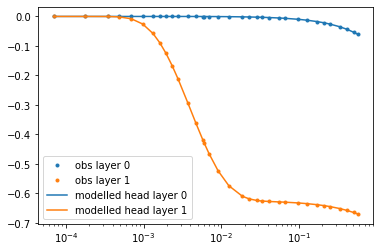

In [13]:
plt.semilogx(tobs, hobs0, '.C0', label="obs layer 0")
plt.semilogx(tobs, hobs1, '.C1', label="obs layer 1")

hm = ml.head(robs, 0, tobs)
plt.semilogx(tobs, hm[0], 'C0', label="modelled head layer 0")
plt.semilogx(tobs, hm[1], 'C1', label="modelled head layer 1")

plt.legend(loc="best")